# ==== has_epilepsy 分类：0–72小时完整流水线（带“病人共同特征交集”） ====

[Info] 交集特征数: 95 / 159 (阈值=0.95); 示例: ['BCI', 'BSAR', 'SIQ', 'SIQ_alpha', 'SIQ_beta', 'SIQ_delta', 'SIQ_theta', 'SignalSD']
[Info] 最终样本: N=19, T=73, F=95
[Info][LOO] Device: cpu, N=19, T=73, F=95


Time points (LOO): 100%|████████████████████████| 73/73 [24:00<00:00, 19.73s/it]


[OK][LOO] Metrics saved to has_epilepsy_lstm_0_72_loo.csv


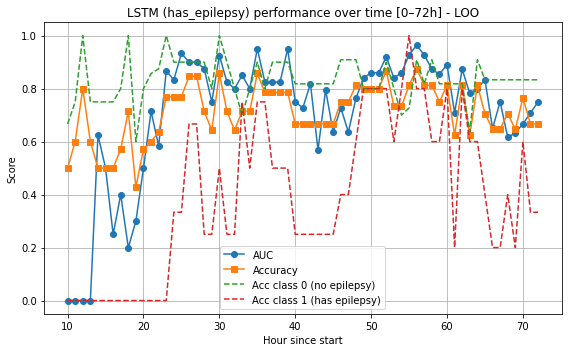

In [4]:


import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# -------------------------
# 全局设置
# -------------------------
NON_FEATURE_COLS = ['study_id', 'h5_folder_id', 'has_epilepsy', 'bin_start_hr', 'bin_end_hr']

def set_seed(s: int = 42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)

# -------------------------
# 预处理（patient-level 时序）+ 病人特征交集
# -------------------------
def preprocess_seq_epilepsy(
    path_csv: str,
    start: int = 0,
    end: int = 72,
    agg_label: str = 'any_true',        # 'any_true' 或 'majority'
    restrict_to_intersection: bool = True,
    min_patient_coverage: float = 1.0   # 1.0=严格交集；可放宽为 0.95 / 0.9 等
):
    """
    读取宽表，构建 (N, T, F) 的时序特征，以及 (N,) 的 patient-level 标签 y∈{0,1}。
    - 特征列 = 除 NON_FEATURE_COLS 外的所有列
    - 标签：按患者聚合 has_epilepsy（any_true 或 majority）
    - 时间轴：使用 bin_start_hr 对齐到 [start, end]（包含 end）
    - 可选：仅保留在时间窗内“≥ min_patient_coverage 比例病人至少有一个非缺失值”的特征
    """
    df = pd.read_csv(path_csv)

    # 基础检查
    needed = ['study_id', 'has_epilepsy', 'bin_start_hr']
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"缺少必要列: {missing}")

    # 类型清洗
    df['bin_start_hr'] = pd.to_numeric(df['bin_start_hr'], errors='coerce')
    df = df.dropna(subset=['study_id', 'bin_start_hr', 'has_epilepsy'])

    # 先限定到目标时间窗（交集依据真实训练窗）
    df_win = df[(df['bin_start_hr'] >= start) & (df['bin_start_hr'] <= end)].copy()
    if df_win.empty:
        raise ValueError("所选时间窗内没有数据")

    # 候选特征列（剔除非特征列 & 全空列）
    all_cols = df_win.columns.tolist()
    feat_cols = [c for c in all_cols if c not in NON_FEATURE_COLS]
    feat_cols = [c for c in feat_cols if not df_win[c].isna().all()]

    # ====== 病人级特征覆盖率 -> 取交集（或放宽阈值）======
    if restrict_to_intersection:
        # 对每个病人、每个特征：该病人在窗口内是否至少出现过非缺失值
        coverage_per_pid = (
            df_win.groupby('study_id')[feat_cols]
                 .apply(lambda g: g.notna().any(axis=0))
        )  # DataFrame, index=pid, columns=feat, bool
        feat_coverage = coverage_per_pid.mean(axis=0)  # 0~1
        kept_feats = feat_coverage[feat_coverage >= min_patient_coverage].index.tolist()

        if len(kept_feats) == 0:
            # 若严格交集过于苛刻，降级为按覆盖率 Top-K（避免空集）
            top_k = min(50, len(feat_cols))
            kept_feats = feat_coverage.sort_values(ascending=False).index[:top_k].tolist()
            print(f"[Warn] 严格交集为空，已改用覆盖率Top-{top_k}特征。")

        print(f"[Info] 交集特征数: {len(kept_feats)} / {len(feat_cols)} "
              f"(阈值={min_patient_coverage:.2f}); 示例: {kept_feats[:8]}")
        feat_cols = kept_feats

    # 数值清洗（在确定最终 feat_cols 后再做）
    df_win[feat_cols] = df_win[feat_cols].replace([np.inf, -np.inf], np.nan)
    df_win[feat_cols] = df_win[feat_cols].astype(float).fillna(df_win[feat_cols].mean(numeric_only=True))
    df_win[feat_cols] = df_win[feat_cols].apply(
        lambda col: np.nan_to_num(col, nan=0.0, posinf=0.0, neginf=0.0)
    )

    # 病人级标签聚合
    lab_df = df_win[['study_id', 'has_epilepsy']].copy()
    if agg_label == 'any_true':
        lab_agg = lab_df.groupby('study_id')['has_epilepsy'].any().astype(int).rename('y')
    elif agg_label == 'majority':
        lab_agg = (lab_df.groupby('study_id')['has_epilepsy'].mean().round().astype(int).rename('y'))
    else:
        raise ValueError("agg_label 仅支持 'any_true' 或 'majority'")

    # 组装时序
    T = end - start + 1  # 包含 end
    X_list, y_list, pids = [], [], []

    for pid, g in df_win.groupby('study_id'):
        seq = np.zeros((T, len(feat_cols)), dtype=np.float32)
        for _, row in g.iterrows():
            h = int(row['bin_start_hr'])
            idx = h - start
            if 0 <= idx < T:
                seq[idx] = row[feat_cols].values.astype(np.float32)
        if (seq != 0).any():  # 至少有一处非零
            X_list.append(seq)
            y_list.append(int(lab_agg.get(pid, 0)))
            pids.append(pid)

    if not X_list:
        return (np.empty((0, T, len(feat_cols)), dtype=np.float32),
                np.empty((0,), dtype=np.int64),
                feat_cols, [])

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int64)
    print(f"[Info] 最终样本: N={len(pids)}, T={T}, F={len(feat_cols)}")
    return X, y, feat_cols, pids

# -------------------------
# LSTM + 注意力（二分类）
# -------------------------
class LSTMBinary(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_layers=1, bidirectional=True, dropout=0.2):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(
            input_dim, hidden_size, num_layers=num_layers,
            batch_first=True, bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.attn_proj = nn.Linear(hidden_size * self.num_directions, hidden_size * self.num_directions)
        self.attn_score = nn.Linear(hidden_size * self.num_directions, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * self.num_directions, 1)

    def forward(self, x):
        # x: [B, T, F]
        H, _ = self.lstm(x)                       # [B, T, D*H]
        H = self.dropout(H)
        u = torch.tanh(self.attn_proj(H))         # [B, T, D*H]
        scores = self.attn_score(u).squeeze(-1)   # [B, T]
        alpha = torch.softmax(scores, dim=1).unsqueeze(-1)  # [B, T, 1]
        z = torch.sum(alpha * H, dim=1)           # [B, D*H]
        return self.fc(z).view(-1)                # logits [B]

# -------------------------
# 训练辅助：类别平衡（复制）
# -------------------------
def balance_by_duplication(X, y):
    classes = np.unique(y)
    counts = {c: int((y == c).sum()) for c in classes}
    max_n = max(counts.values())

    X_out, y_out = [], []
    for c in classes:
        Xc = X[y == c]
        n_needed = max_n - len(Xc)
        if n_needed > 0:
            X_aug = resample(Xc, replace=True, n_samples=n_needed, random_state=42)
            Xc = np.concatenate([Xc, X_aug], axis=0)
        X_out.append(Xc)
        y_out.append(np.full((len(Xc),), c, dtype=np.int64))
    return np.concatenate(X_out, axis=0), np.concatenate(y_out, axis=0)

# -------------------------
# 主训练/评估流程（时间递增）
# -------------------------
from sklearn.model_selection import LeaveOneOut

def run_task_epilepsy_loo(
    path_csv: str,
    start: int = 0,
    end: int = 72,
    hidden_size: int = 64,
    num_layers: int = 1,
    bidirectional: bool = True,
    dropout: float = 0.2,
    epochs: int = 60,
    batch_size: int = 64,
    out_csv: str = 'has_epilepsy_lstm_0_72_loo.csv',
    agg_label: str = 'any_true',
    restrict_to_intersection: bool = True,
    min_patient_coverage: float = 1.0,
    use_duplication: bool = True,      # 训练集内复制采样
    use_pos_weight: bool = True        # BCE 正负样本权重
):
    # 预处理（含交集）
    X_np, y_np, feat_cols, pids = preprocess_seq_epilepsy(
        path_csv, start=start, end=end, agg_label=agg_label,
        restrict_to_intersection=restrict_to_intersection,
        min_patient_coverage=min_patient_coverage
    )
    N, T, F = X_np.shape
    if N < 2:
        print("LOO 需要至少 2 名患者。")
        return None

    set_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"[Info][LOO] Device: {device}, N={N}, T={T}, F={F}")

    loo = LeaveOneOut()
    records = []

    # 时间递增：L=1..T（对应小时 start..end）
    for L in tqdm(range(1, T + 1), desc="Time points (LOO)"):
        tp = start + L - 1

        # 收集所有 LOO 测试的预测/标签
        all_probs, all_preds, all_true = [], [], []

        # 可选的“非零步数”过滤（在 LOO 之前做：只保留 >=10% 非零时间步的患者）
        Xw = X_np[:, :L, :].copy()
        yw = y_np.copy()
        nonzero_counts = (Xw != 0).any(axis=2).sum(axis=1)
        mask_pat = nonzero_counts >= max(1, int(0.1 * L))
        Xw, yw = Xw[mask_pat], yw[mask_pat]
        if len(np.unique(yw)) < 2 or len(yw) < 2:
            records.append({'hour': tp, 'AUC': np.nan, 'Accuracy': np.nan,
                            'Acc_class_0': np.nan, 'Acc_class_1': np.nan})
            continue

        for train_index, test_index in loo.split(Xw):
            Xtr, Xte = Xw[train_index].copy(), Xw[test_index].copy()
            ytr, yte = yw[train_index], yw[test_index]

            # 若训练集中只有单一类别，则跳过（或直接用多数类规则）
            if len(np.unique(ytr)) < 2:
                # 简单规则：始终预测多数类；这条对最终 AUC 影响小，但能给出 Acc/混淆
                majority = int(np.bincount(ytr).argmax())
                all_true.append(int(yte[0]))
                all_preds.append(majority)
                all_probs.append(float(majority))  # 伪概率
                continue

            # ---- 缩放：仅在训练集 fit ----
            scaler = MinMaxScaler()
            scaler.fit(Xtr.reshape(-1, F))
            Xtr = scaler.transform(Xtr.reshape(-1, F)).reshape(Xtr.shape[0], L, F)
            Xte = scaler.transform(Xte.reshape(-1, F)).reshape(Xte.shape[0], L, F)

            # ---- 复制采样（训练集内部）----
            if use_duplication:
                Xtr_bal, ytr_bal = balance_by_duplication(Xtr, ytr)
            else:
                Xtr_bal, ytr_bal = Xtr, ytr

            train_loader = DataLoader(
                TensorDataset(torch.tensor(Xtr_bal, dtype=torch.float32),
                              torch.tensor(ytr_bal, dtype=torch.float32)),
                batch_size=batch_size, shuffle=True
            )

            # 模型
            model = LSTMBinary(
                input_dim=F, hidden_size=hidden_size, num_layers=num_layers,
                bidirectional=bidirectional, dropout=dropout
            ).to(device)

            # BCE 损失，可选 pos_weight
            if use_pos_weight:
                pos = float((ytr_bal == 1).sum())
                neg = float((ytr_bal == 0).sum())
                pw = max(1.0, neg / max(1.0, pos))
                pos_weight = torch.tensor([pw], dtype=torch.float32).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            else:
                criterion = nn.BCEWithLogitsLoss()

            optimizer = optim.Adam(model.parameters(), lr=1e-3)

            # 训练
            for _ in range(epochs):
                model.train()
                for xb, yb in train_loader:
                    xb = xb.to(device); yb = yb.to(device)
                    optimizer.zero_grad()
                    logits = model(xb).view(-1)
                    loss = criterion(logits, yb)
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()

            # 测试（单个病人）
            model.eval()
            with torch.no_grad():
                xb = torch.tensor(Xte, dtype=torch.float32).to(device)
                prob = torch.sigmoid(model(xb).view(-1)).cpu().numpy()[0]
                pred = int(prob >= 0.5)
            all_true.append(int(yte[0]))
            all_probs.append(float(prob))
            all_preds.append(pred)

        # 聚合度量（该小时 L）
        y_true = np.array(all_true, dtype=int)
        y_pred = np.array(all_preds, dtype=int)
        y_prob = np.array(all_probs, dtype=float)

        # AUC：需要两类都出现
        if len(np.unique(y_true)) < 2:
            auc = np.nan
        else:
            try:
                auc = roc_auc_score(y_true, y_prob)
            except Exception:
                auc = np.nan

        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        # 分类别准确率
        acc_c0 = (cm[0,0] / cm[0].sum()) if cm[0].sum() > 0 else np.nan
        acc_c1 = (cm[1,1] / cm[1].sum()) if cm[1].sum() > 0 else np.nan

        records.append({'hour': tp, 'AUC': auc, 'Accuracy': acc,
                        'Acc_class_0': acc_c0, 'Acc_class_1': acc_c1})

    df_metrics = pd.DataFrame(records)
    df_metrics.to_csv(out_csv, index=False)
    print(f"[OK][LOO] Metrics saved to {out_csv}")

    plt.figure(figsize=(8,5))
    plt.plot(df_metrics['hour'], df_metrics['AUC'], '-o', label='AUC')
    plt.plot(df_metrics['hour'], df_metrics['Accuracy'], '-s', label='Accuracy')
    plt.plot(df_metrics['hour'], df_metrics['Acc_class_0'], '--', label='Acc class 0 (no epilepsy)')
    plt.plot(df_metrics['hour'], df_metrics['Acc_class_1'], '--', label='Acc class 1 (has epilepsy)')
    plt.xlabel('Hour since start'); plt.ylabel('Score')
    plt.title('LSTM (has_epilepsy) performance over time [0–72h] - LOO')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return df_metrics 

metrics_loo = run_task_epilepsy_loo(
    path_csv="all_patient_features_epilepsy_1h_violin_wide.csv",
    start=0, end=72,
    hidden_size=32, num_layers=1, bidirectional=True, dropout=0.2,
    epochs=80, batch_size=64,
    out_csv="has_epilepsy_lstm_0_72_loo.csv",
    agg_label='any_true',
    restrict_to_intersection=True,
    min_patient_coverage=0.95,   # 可先放宽到 0.95 提高 N
    use_duplication=True,
    use_pos_weight=True
)

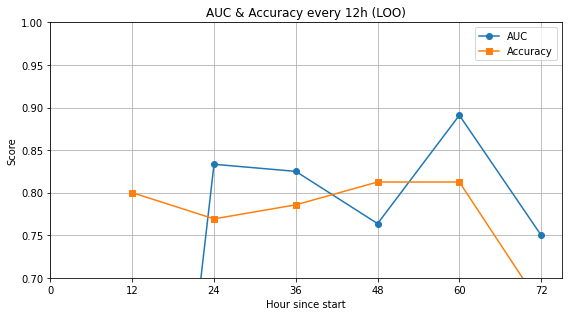

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "has_epilepsy_lstm_0_72_loo.csv"
df = pd.read_csv(csv_path)

target_hours = list(range(0, 73, 12))
df_12h = df[df["hour"].isin(target_hours)].sort_values("hour")[["hour", "AUC", "Accuracy"]]

plt.figure(figsize=(8,4.5))
plt.plot(df_12h["hour"], df_12h["AUC"], "-o", label="AUC")
plt.plot(df_12h["hour"], df_12h["Accuracy"], "-s", label="Accuracy")
plt.title("AUC & Accuracy every 12h (LOO)")
plt.xlabel("Hour since start"); plt.ylabel("Score")
plt.xticks(target_hours)
plt.ylim(0.7, 1.0)   # <-- 聚焦在0.7~1.0
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# ==== has_epilepsy 分类：0–72h LOO + 每12小时特征重要性（Grad×Input） ====


[Info] 交集特征数: 95 / 159 (阈值=0.95); 示例: ['BCI', 'BSAR', 'SIQ', 'SIQ_alpha', 'SIQ_beta', 'SIQ_delta', 'SIQ_theta', 'SignalSD']
[Info] 最终样本: N=19, T=73, F=95
[Info][LOO] Device: cpu, N=19, T=73, F=95


Time points (LOO): 100%|████████████████████████| 73/73 [22:29<00:00, 18.49s/it]


[OK][LOO] Metrics saved to has_epilepsy_lstm_0_72_loo.csv


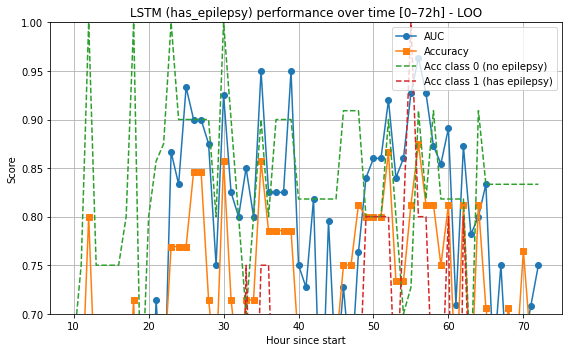

[Info] hour=0: 无可用的 saliency（可能该小时被跳过或训练集单一类别）。
[OK] saved imp_heatmap_hour12.png
[OK] saved feature_importance_hour12.csv & _normalized.csv
[OK] saved imp_heatmap_hour24.png
[OK] saved feature_importance_hour24.csv & _normalized.csv
[OK] saved imp_heatmap_hour36.png
[OK] saved feature_importance_hour36.csv & _normalized.csv
[OK] saved imp_heatmap_hour48.png
[OK] saved feature_importance_hour48.csv & _normalized.csv
[OK] saved imp_heatmap_hour60.png
[OK] saved feature_importance_hour60.csv & _normalized.csv
[OK] saved imp_heatmap_hour72.png
[OK] saved feature_importance_hour72.csv & _normalized.csv


In [7]:

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, List, Dict
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# -------------------------
# 全局设置
# -------------------------
NON_FEATURE_COLS = ['study_id', 'h5_folder_id', 'has_epilepsy', 'bin_start_hr', 'bin_end_hr']

def set_seed(s: int = 42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)

# -------------------------
# 预处理（patient-level 时序）+ 病人特征交集
# -------------------------
def preprocess_seq_epilepsy(
    path_csv: str,
    start: int = 0,
    end: int = 72,
    agg_label: str = 'any_true',        # 'any_true' 或 'majority'
    restrict_to_intersection: bool = True,
    min_patient_coverage: float = 1.0   # 1.0=严格交集；可放宽为 0.95 / 0.9 等
):
    """
    读取宽表，构建 (N, T, F) 的时序特征，以及 (N,) 的 patient-level 标签 y∈{0,1}。
    - 特征列 = 除 NON_FEATURE_COLS 外的所有列
    - 标签：按患者聚合 has_epilepsy（any_true 或 majority）
    - 时间轴：使用 bin_start_hr 对齐到 [start, end]（包含 end）
    - 可选：仅保留在时间窗内“≥ min_patient_coverage 比例病人至少有一个非缺失值”的特征
    """
    df = pd.read_csv(path_csv)

    # 基础检查
    needed = ['study_id', 'has_epilepsy', 'bin_start_hr']
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"缺少必要列: {missing}")

    # 类型清洗
    df['bin_start_hr'] = pd.to_numeric(df['bin_start_hr'], errors='coerce')
    df = df.dropna(subset=['study_id', 'bin_start_hr', 'has_epilepsy'])

    # 先限定到目标时间窗（交集依据真实训练窗）
    df_win = df[(df['bin_start_hr'] >= start) & (df['bin_start_hr'] <= end)].copy()
    if df_win.empty:
        raise ValueError("所选时间窗内没有数据")

    # 候选特征列（剔除非特征列 & 全空列）
    all_cols = df_win.columns.tolist()
    feat_cols = [c for c in all_cols if c not in NON_FEATURE_COLS]
    feat_cols = [c for c in feat_cols if not df_win[c].isna().all()]

    # ====== 病人级特征覆盖率 -> 取交集（或放宽阈值）======
    if restrict_to_intersection:
        coverage_per_pid = (
            df_win.groupby('study_id')[feat_cols]
                 .apply(lambda g: g.notna().any(axis=0))
        )  # DataFrame, index=pid, columns=feat, bool
        feat_coverage = coverage_per_pid.mean(axis=0)  # 0~1
        kept_feats = feat_coverage[feat_coverage >= min_patient_coverage].index.tolist()

        if len(kept_feats) == 0:
            top_k = min(50, len(feat_cols))
            kept_feats = feat_coverage.sort_values(ascending=False).index[:top_k].tolist()
            print(f"[Warn] 严格交集为空，已改用覆盖率Top-{top_k}特征。")

        print(f"[Info] 交集特征数: {len(kept_feats)} / {len(feat_cols)} "
              f"(阈值={min_patient_coverage:.2f}); 示例: {kept_feats[:8]}")
        feat_cols = kept_feats

    # 数值清洗（在确定最终 feat_cols 后再做）
    df_win[feat_cols] = df_win[feat_cols].replace([np.inf, -np.inf], np.nan)
    df_win[feat_cols] = df_win[feat_cols].astype(float).fillna(df_win[feat_cols].mean(numeric_only=True))
    df_win[feat_cols] = df_win[feat_cols].apply(
        lambda col: np.nan_to_num(col, nan=0.0, posinf=0.0, neginf=0.0)
    )

    # 病人级标签聚合
    lab_df = df_win[['study_id', 'has_epilepsy']].copy()
    if agg_label == 'any_true':
        lab_agg = lab_df.groupby('study_id')['has_epilepsy'].any().astype(int).rename('y')
    elif agg_label == 'majority':
        lab_agg = (lab_df.groupby('study_id')['has_epilepsy'].mean().round().astype(int).rename('y'))
    else:
        raise ValueError("agg_label 仅支持 'any_true' 或 'majority'")

    # 组装时序
    T = end - start + 1  # 包含 end
    X_list, y_list, pids = [], [], []

    for pid, g in df_win.groupby('study_id'):
        seq = np.zeros((T, len(feat_cols)), dtype=np.float32)
        for _, row in g.iterrows():
            h = int(row['bin_start_hr'])
            idx = h - start
            if 0 <= idx < T:
                seq[idx] = row[feat_cols].values.astype(np.float32)
        if (seq != 0).any():  # 至少有一处非零
            X_list.append(seq)
            y_list.append(int(lab_agg.get(pid, 0)))
            pids.append(pid)

    if not X_list:
        return (np.empty((0, T, len(feat_cols)), dtype=np.float32),
                np.empty((0,), dtype=np.int64),
                feat_cols, [])

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int64)
    print(f"[Info] 最终样本: N={len(pids)}, T={T}, F={len(feat_cols)}")
    return X, y, feat_cols, pids

# -------------------------
# LSTM + 注意力（二分类）
# -------------------------
class LSTMBinary(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_layers=1, bidirectional=True, dropout=0.2):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(
            input_dim, hidden_size, num_layers=num_layers,
            batch_first=True, bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.attn_proj = nn.Linear(hidden_size * self.num_directions, hidden_size * self.num_directions)
        self.attn_score = nn.Linear(hidden_size * self.num_directions, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * self.num_directions, 1)

    def forward(self, x):
        # x: [B, T, F]
        H, _ = self.lstm(x)                       # [B, T, D*H]
        H = self.dropout(H)
        u = torch.tanh(self.attn_proj(H))         # [B, T, D*H]
        scores = self.attn_score(u).squeeze(-1)   # [B, T]
        alpha = torch.softmax(scores, dim=1).unsqueeze(-1)  # [B, T, 1]
        z = torch.sum(alpha * H, dim=1)           # [B, D*H]
        return self.fc(z).view(-1)                # logits [B]

# -------------------------
# 训练辅助：类别平衡（复制）
# -------------------------
def balance_by_duplication(X, y):
    classes = np.unique(y)
    counts = {c: int((y == c).sum()) for c in classes}
    max_n = max(counts.values())

    X_out, y_out = [], []
    for c in classes:
        Xc = X[y == c]
        n_needed = max_n - len(Xc)
        if n_needed > 0:
            X_aug = resample(Xc, replace=True, n_samples=n_needed, random_state=42)
            Xc = np.concatenate([Xc, X_aug], axis=0)
        X_out.append(Xc)
        y_out.append(np.full((len(Xc),), c, dtype=np.int64))
    return np.concatenate(X_out, axis=0), np.concatenate(y_out, axis=0)

# -------------------------
# Grad×Input（与本模型匹配）
# -------------------------
def saliency_feature_timeseries_simple(model: nn.Module, X: np.ndarray) -> np.ndarray:
    """
    X: [N, T, F]
    返回 imp: [N, T, F]，= |grad * input|
    """
    model.eval()
    device = next(model.parameters()).device
    Xt = torch.tensor(X, dtype=torch.float32, requires_grad=True, device=device)
    logits = model(Xt)                 # [N]
    if logits.ndim > 1:
        logits = logits.view(-1)
    target = logits.sum()
    model.zero_grad(set_to_none=True)
    if Xt.grad is not None:
        Xt.grad.zero_()
    target.backward()
    grad = Xt.grad.detach().cpu().numpy()   # [N,T,F]
    imp = np.abs(grad * X)                  # Grad×Input
    return imp

# -------------------------
# LOO 主流程（每12小时做重要性）
# -------------------------
def run_task_epilepsy_loo(
    path_csv: str,
    start: int = 0,
    end: int = 72,
    hidden_size: int = 64,
    num_layers: int = 1,
    bidirectional: bool = True,
    dropout: float = 0.2,
    epochs: int = 60,
    batch_size: int = 64,
    out_csv: str = 'has_epilepsy_lstm_0_72_loo.csv',
    agg_label: str = 'any_true',
    restrict_to_intersection: bool = True,
    min_patient_coverage: float = 1.0,
    use_duplication: bool = True,      # 训练集内复制采样
    use_pos_weight: bool = True,       # BCE 正负样本权重
    # 重要性配置（每12小时）
    importance_hours: Optional[List[int]] = None,   # 若为 None，自动设为 [0,12,...,72]
    topk: int = 30,
    heatmap_prefix: str = "imp_heatmap_hour",
    focus_ylim: Optional[tuple] = (0.7, 1.0)        # 主图y轴范围；设 None 不限制
):
    # 预处理（含交集）
    X_np, y_np, feat_cols, pids = preprocess_seq_epilepsy(
        path_csv, start=start, end=end, agg_label=agg_label,
        restrict_to_intersection=restrict_to_intersection,
        min_patient_coverage=min_patient_coverage
    )
    N, T, F = X_np.shape
    if N < 2:
        print("LOO 需要至少 2 名患者。")
        return None

    set_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"[Info][LOO] Device: {device}, N={N}, T={T}, F={F}")

    loo = LeaveOneOut()
    records = []

    # 每12小时列表
    if importance_hours is None:
        importance_hours = list(range(start, end + 1, 12))
    importance_hours = sorted([h for h in importance_hours if start <= h <= end])
    imp_collect: Dict[int, List[np.ndarray]] = {h: [] for h in importance_hours}

    # 时间递增：L=1..T（对应小时 start..end）
    for L in tqdm(range(1, T + 1), desc="Time points (LOO)"):
        tp = start + L - 1

        all_probs, all_preds, all_true = [], [], []

        Xw = X_np[:, :L, :].copy()
        yw = y_np.copy()
        nonzero_counts = (Xw != 0).any(axis=2).sum(axis=1)
        mask_pat = nonzero_counts >= max(1, int(0.1 * L))
        Xw, yw = Xw[mask_pat], yw[mask_pat]
        if len(np.unique(yw)) < 2 or len(yw) < 2:
            records.append({'hour': tp, 'AUC': np.nan, 'Accuracy': np.nan,
                            'Acc_class_0': np.nan, 'Acc_class_1': np.nan})
            continue

        for train_index, test_index in loo.split(Xw):
            Xtr, Xte = Xw[train_index].copy(), Xw[test_index].copy()
            ytr, yte = yw[train_index], yw[test_index]

            if len(np.unique(ytr)) < 2:
                majority = int(np.bincount(ytr).argmax())
                all_true.append(int(yte[0]))
                all_preds.append(majority)
                all_probs.append(float(majority))
                continue

            # 缩放：仅在训练集 fit
            scaler = MinMaxScaler()
            scaler.fit(Xtr.reshape(-1, F))
            Xtr = scaler.transform(Xtr.reshape(-1, F)).reshape(Xtr.shape[0], L, F)
            Xte = scaler.transform(Xte.reshape(-1, F)).reshape(Xte.shape[0], L, F)

            # 复制采样
            if use_duplication:
                Xtr_bal, ytr_bal = balance_by_duplication(Xtr, ytr)
            else:
                Xtr_bal, ytr_bal = Xtr, ytr

            train_loader = DataLoader(
                TensorDataset(torch.tensor(Xtr_bal, dtype=torch.float32),
                              torch.tensor(ytr_bal, dtype=torch.float32)),
                batch_size=batch_size, shuffle=True
            )

            # 模型
            model = LSTMBinary(
                input_dim=F, hidden_size=hidden_size, num_layers=num_layers,
                bidirectional=bidirectional, dropout=dropout
            ).to(device)

            # 损失
            if use_pos_weight:
                pos = float((ytr_bal == 1).sum())
                neg = float((ytr_bal == 0).sum())
                pw = max(1.0, neg / max(1.0, pos))
                pos_weight = torch.tensor([pw], dtype=torch.float32).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            else:
                criterion = nn.BCEWithLogitsLoss()

            optimizer = optim.Adam(model.parameters(), lr=1e-3)

            # 训练
            for _ in range(epochs):
                model.train()
                for xb, yb in train_loader:
                    xb = xb.to(device); yb = yb.to(device)
                    optimizer.zero_grad()
                    logits = model(xb).view(-1)
                    loss = criterion(logits, yb)
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()

            # 测试（单个病人）
            model.eval()
            with torch.no_grad():
                xb = torch.tensor(Xte, dtype=torch.float32).to(device)
                prob = torch.sigmoid(model(xb).view(-1)).cpu().numpy()[0]
                pred = int(prob >= 0.5)
            all_true.append(int(yte[0]))
            all_probs.append(float(prob))
            all_preds.append(pred)

            # 重要性（仅在指定小时）
            if tp in imp_collect:
                imp_ntf = saliency_feature_timeseries_simple(model, Xte)  # [1, L, F]
                imp_collect[tp].append(imp_ntf)  # 收集

        # 聚合该小时的 AUC/ACC
        y_true = np.array(all_true, dtype=int)
        y_pred = np.array(all_preds, dtype=int)
        y_prob = np.array(all_probs, dtype=float)

        if len(np.unique(y_true)) < 2:
            auc = np.nan
        else:
            try:
                auc = roc_auc_score(y_true, y_prob)
            except Exception:
                auc = np.nan

        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        acc_c0 = (cm[0,0] / cm[0].sum()) if cm[0].sum() > 0 else np.nan
        acc_c1 = (cm[1,1] / cm[1].sum()) if cm[1].sum() > 0 else np.nan

        records.append({'hour': tp, 'AUC': auc, 'Accuracy': acc,
                        'Acc_class_0': acc_c0, 'Acc_class_1': acc_c1})

    # 保存时序指标
    df_metrics = pd.DataFrame(records)
    df_metrics.to_csv(out_csv, index=False)
    print(f"[OK][LOO] Metrics saved to {out_csv}")

    # 画主图（可选放大y轴范围）
    plt.figure(figsize=(8,5))
    plt.plot(df_metrics['hour'], df_metrics['AUC'], '-o', label='AUC')
    plt.plot(df_metrics['hour'], df_metrics['Accuracy'], '-s', label='Accuracy')
    plt.plot(df_metrics['hour'], df_metrics['Acc_class_0'], '--', label='Acc class 0 (no epilepsy)')
    plt.plot(df_metrics['hour'], df_metrics['Acc_class_1'], '--', label='Acc class 1 (has epilepsy)')
    plt.xlabel('Hour since start'); plt.ylabel('Score')
    plt.title('LSTM (has_epilepsy) performance over time [0–72h] - LOO')
    if focus_ylim is not None:
        plt.ylim(*focus_ylim)  # 聚焦 0.7~1.0
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # ---- 汇总并输出重要性结果（每个指定小时各一套）----
    for hr in importance_hours:
        if len(imp_collect[hr]) == 0:
            print(f"[Info] hour={hr}: 无可用的 saliency（可能该小时被跳过或训练集单一类别）。")
            continue
        # 每个元素是 [1, L, F]，压掉batch维 -> [L, F]，再跨LOO平均
        stacks = [arr.squeeze(0) for arr in imp_collect[hr]]   # -> [L, F]
        imp_LF = np.stack(stacks, axis=0).mean(axis=0)         # [L, F]

        # 热力图：Top-K 特征（按时间均值排序）
        feat_scores = imp_LF.mean(axis=0)          # [F]
        top_idx = np.argsort(-feat_scores)[:min(topk, len(feat_cols))]
        imp_heat = imp_LF[:, top_idx]              # [L, K]
        hours_axis = np.arange(start, hr + 1)      # L 个小时

        plt.figure(figsize=(10, 6))
        plt.imshow(imp_heat.T, aspect="auto", origin="lower",
                   extent=[hours_axis[0], hours_axis[-1], 0, len(top_idx)])
        plt.colorbar(label="Grad×Input importance")
        plt.yticks(np.arange(len(top_idx)) + 0.5, [feat_cols[i] for i in top_idx], fontsize=7)
        plt.xlabel("Hour since start")
        plt.ylabel("Top features")
        plt.title(f"Saliency heatmap (LOO avg) up to hour={hr}")
        plt.tight_layout()
        out_png = f"{heatmap_prefix}{hr}.png"
        plt.savefig(out_png, dpi=180)
        plt.close()
        print(f"[OK] saved {out_png}")

        # 导出该小时的全局特征排名（时间均值->每特征一个分数）
        s = pd.Series(feat_scores, index=feat_cols).sort_values(ascending=False)
        s.to_csv(f"feature_importance_hour{hr}.csv")
        s_norm = (s / s.sum()).rename("importance_share")
        s_norm.to_csv(f"feature_importance_hour{hr}_normalized.csv")
        print(f"[OK] saved feature_importance_hour{hr}.csv & _normalized.csv")

    return df_metrics

# -------------------------
# 用法示例（按需修改路径）
# -------------------------
if __name__ == "__main__":
    set_seed(42)
    metrics_loo = run_task_epilepsy_loo(
        path_csv="all_patient_features_epilepsy_1h_violin_wide.csv",  # 改为你的CSV路径
        start=0, end=72,
        hidden_size=32, num_layers=1, bidirectional=True, dropout=0.2,
        epochs=80, batch_size=64,
        out_csv="has_epilepsy_lstm_0_72_loo.csv",
        agg_label='any_true',
        restrict_to_intersection=True,
        min_patient_coverage=0.95,          # 可放宽到 0.90 提高 N
        use_duplication=True,
        use_pos_weight=True,
        importance_hours=list(range(0, 73, 12)),  # 每12小时：0,12,...,72
        topk=30,
        heatmap_prefix="imp_heatmap_hour",
        focus_ylim=(0.7, 1.0)               # 主图只看 0.7~1.0
    )

In [10]:
import pandas as pd

hours = [12, 24, 36, 48, 60, 72]

for h in hours:
    print(f"\n===== Hour {h} (raw scores) =====")
    df_raw = pd.read_csv(f"feature_importance_hour{h}.csv", index_col=0)
    # 如果只有一列，就转成 Series
    if df_raw.shape[1] == 1:
        df_raw = df_raw.iloc[:, 0]
    top10_raw = df_raw.sort_values(ascending=False).head(10)
    for feat, val in top10_raw.items():
        print(f"{feat:<30s} {val:.6f}")

    print(f"\n===== Hour {h} (normalized shares) =====")
    df_norm = pd.read_csv(f"feature_importance_hour{h}_normalized.csv", index_col=0)
    if df_norm.shape[1] == 1:
        df_norm = df_norm.iloc[:, 0]
    top10_norm = df_norm.sort_values(ascending=False).head(10)
    for feat, val in top10_norm.items():
        print(f"{feat:<30s} {val:.4%}")


===== Hour 12 (raw scores) =====
deltaalphamean                 0.010056
thetaalphamean                 0.009319
lv_l5                          0.009129
deltaalphastd                  0.008911
sdspectkurt                    0.008641
pctpeakpoint                   0.008318
deltastdrat                    0.008102
deltakurtosis                  0.007993
alphastdrat                    0.007921
deltaalphapct                  0.007545

===== Hour 12 (normalized shares) =====
deltaalphamean                 2.8404%
thetaalphamean                 2.6323%
lv_l5                          2.5786%
deltaalphastd                  2.5168%
sdspectkurt                    2.4407%
pctpeakpoint                   2.3495%
deltastdrat                    2.2885%
deltakurtosis                  2.2577%
alphastdrat                    2.2374%
deltaalphapct                  2.1310%

===== Hour 24 (raw scores) =====
SIQ_alpha                      0.023234
SIQ_beta                       0.019435
SIQ_theta            

[Info] 交集特征数: 24 / 26 (阈值=0.95); 示例: ['bin_start_hr.1', 'bin_end_hr.1', 'alpha_kurtosis_mean', 'alpha_lyap_mean', 'alpha_sentropy_mean', 'alpha_syn', 'alpha_wentropy_mean', 'beta_kurtosis_mean']
[Info] 最终样本: N=20, T=73, F=24
[Info][LOO] Device: cpu, N=20, T=73, F=24


Time points (LOO): 100%|████████████████████████| 73/73 [14:24<00:00, 11.85s/it]


[OK][LOO] Metrics saved to has_epilepsy_lstm_0_72_loo.csv


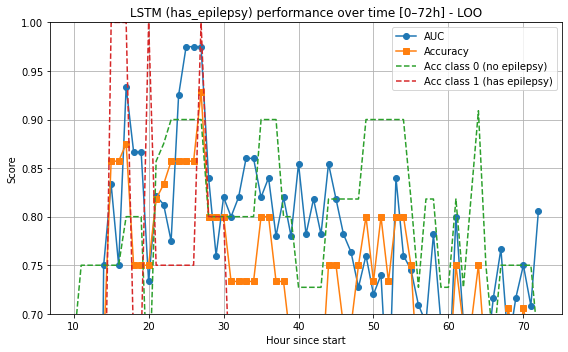

[Info] hour=0: 无可用的 saliency（可能该小时被跳过或训练集单一类别）。
[OK] saved imp_heatmap_hour12.png
[OK] saved feature_importance_hour12.csv & _normalized.csv
[OK] saved imp_heatmap_hour24.png
[OK] saved feature_importance_hour24.csv & _normalized.csv
[OK] saved imp_heatmap_hour36.png
[OK] saved feature_importance_hour36.csv & _normalized.csv
[OK] saved imp_heatmap_hour48.png
[OK] saved feature_importance_hour48.csv & _normalized.csv
[OK] saved imp_heatmap_hour60.png
[OK] saved feature_importance_hour60.csv & _normalized.csv
[OK] saved imp_heatmap_hour72.png
[OK] saved feature_importance_hour72.csv & _normalized.csv


In [11]:
if __name__ == "__main__":
    set_seed(42)
    metrics_loo = run_task_epilepsy_loo(
        path_csv="all_patient_info_features_epilepsy_1h_violin_wide_cleaned.csv",  # 改为你的CSV路径
        start=0, end=72,
        hidden_size=32, num_layers=1, bidirectional=True, dropout=0.2,
        epochs=80, batch_size=64,
        out_csv="has_epilepsy_lstm_0_72_loo.csv",
        agg_label='any_true',
        restrict_to_intersection=True,
        min_patient_coverage=0.95,          # 可放宽到 0.90 提高 N
        use_duplication=True,
        use_pos_weight=True,
        importance_hours=list(range(0, 73, 12)),  # 每12小时：0,12,...,72
        topk=30,
        heatmap_prefix="imp_heatmap_hour",
        focus_ylim=(0.7, 1.0)               # 主图只看 0.7~1.0
    )

In [12]:
import pandas as pd

hours = [12, 24, 36, 48, 60, 72]

for h in hours:
    print(f"\n===== Hour {h} (raw scores) =====")
    df_raw = pd.read_csv(f"feature_importance_hour{h}.csv", index_col=0)
    # 如果只有一列，就转成 Series
    if df_raw.shape[1] == 1:
        df_raw = df_raw.iloc[:, 0]
    top10_raw = df_raw.sort_values(ascending=False).head(10)
    for feat, val in top10_raw.items():
        print(f"{feat:<30s} {val:.6f}")

    print(f"\n===== Hour {h} (normalized shares) =====")
    df_norm = pd.read_csv(f"feature_importance_hour{h}_normalized.csv", index_col=0)
    if df_norm.shape[1] == 1:
        df_norm = df_norm.iloc[:, 0]
    top10_norm = df_norm.sort_values(ascending=False).head(10)
    for feat, val in top10_norm.items():
        print(f"{feat:<30s} {val:.4%}")


===== Hour 12 (raw scores) =====
alpha_wentropy_mean            0.037028
delta_wentropy_mean            0.035608
alpha_kurtosis_mean            0.032536
beta_wentropy_mean             0.028346
theta_wentropy_mean            0.027445
beta_kurtosis_mean             0.027237
beta_red                       0.024951
theta_sentropy_mean            0.024544
alpha_sentropy_mean            0.018966
beta_lyap_mean                 0.018710

===== Hour 12 (normalized shares) =====
alpha_wentropy_mean            9.0190%
delta_wentropy_mean            8.6729%
alpha_kurtosis_mean            7.9248%
beta_wentropy_mean             6.9041%
theta_wentropy_mean            6.6847%
beta_kurtosis_mean             6.6341%
beta_red                       6.0774%
theta_sentropy_mean            5.9781%
alpha_sentropy_mean            4.6196%
beta_lyap_mean                 4.5572%

===== Hour 24 (raw scores) =====
beta_lyap_mean                 0.043689
theta_lyap_mean                0.039746
alpha_lyap_mean      